# Ground truth recordings for validation of spike sorting algorithms


Spampinato from Institut de la Vision have publish data from mice retina recorded with from dense array.
The data contain one ground truth to benchmark spike sorting tools.

Here the official publication of this open dataset:
https://zenodo.org/record/1205233#.W9mq1HWLTIF


This datasets was used by Pierre Yger publish spyking circus:
https://elifesciences.org/articles/34518


Here a notebook that compare some sorter on theses recording.

Each recording have several units and **one** of theses have a ground truth recorded with juxta cellular.
The SNR on MEA is differents on each file so we can easily compare the false positive and true positive score by sorter and SNR.


all tar.gz files must in "rawfiles" path


In [1]:
import zipfile, tarfile
import re
import os, shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spiketoolkit as st
import spikeextractors as se
import spikewidgets as sw

%matplotlib notebook

## global variables

In [4]:
# my working path
# basedir = '/media/samuel/SamCNRS/DataSpikeSorting/pierre/zenodo/'
basedir = '/mnt/data/sam/DataSpikeSorting/pierre_zenodo/'

# input file
recording_folder = basedir + 'rawfiles/'

# where output will be
working_folder = basedir + 'run_comparison/'

# ground truth information
ground_truth_folder = basedir + 'ground_truth/'

# file_list
rec_names = ['20170629_patch3', '20170728_patch2', '20170630_patch1', '20160426_patch2', '20170621_patch1',
             '20170627_patch1', '20170706_patch3', '20170706_patch1', '20170726_patch1', '20170725_patch1',
             '20160426_patch3', '20170622_patch1', '20170623_patch1', '20170622_patch2', '20170629_patch2',
             '20170713_patch1', '20160415_patch2', '20170706_patch2', '20170803_patch1']
rec_names = ['20160415_patch2','20160426_patch2', '20160426_patch3']

# ambiguous juxta detection
# ['20170630_patch1', '20170627_patch1']
             

# sorter list
sorter_list = ['tridesclous', 'moutainsort4']


## Step 1 : unzip all

This extract tar.gz files to folder

In [ ]:
for rec_name in rec_names:
    filename = recording_folder + rec_name + '.tar.gz'

    if os.path.exists(recording_folder+rec_name) and os.path.isdir(recording_folder+rec_name):
        continue
    t = tarfile.open(filename, mode='r|gz')
    t.extractall(recording_folder+rec_name)

## Step 2 : detect ground truth spike on juxta cellular

This is done in a separate script to keep this doc simple.

The following script:
  * detect GT spikes
  * detect on which MEA channel the spike is
  * get the mea peak value
  * measure the noise on this channel
  * make the ratio peak_value/noise_mad


In [ ]:
%run detect_ground_truth_spike_on_juxta.py

In [11]:
gt_info = pd.read_excel(ground_truth_folder+'gt_info.xlsx', index_col=0)
gt_info.loc[rec_names, :]

,nb_spike,max_on_channel,max_value,mea_peak_snr,noise_mad
20160415_patch2,3514,69,32369.0,704.277142,45.9606
20170630_patch1,2368,232,32106.0,832.892320,38.5476
20170627_patch1,3144,221,32331.0,681.467523,47.4432


## Step 3: run sorters on all files

Important note : the file have 256 channels but only 252 are usefull.
The PRB file contain all channels needed so we need to explicit **grouping_property='group'**
to be sure to only take in account the channel in the unique group.

In [ ]:
# make a recordings dict
recordings = {}
for rec_name in rec_names:
    dirname = recording_folder + rec_name + '/'

    for f in os.listdir(dirname):
        if f.endswith('.raw') and not f.endswith('juxta.raw'):
            raw_filename = dirname + f

    # raw files have an internal offset that depend on the channel count
    # a simple built header can be parsed to get it
    with open(raw_filename.replace('.raw', '.txt'), mode='r') as f:
        offset = int(re.findall('padding = (\d+)', f.read())[0])

    # recording
    rec = se.BinDatRecordingExtractor(raw_filename, 20000, 256, 'uint16', offset=offset, frames_first=True)
    chan_ids = rec.getChannelIds()

    rec = se.loadProbeFile(rec, basedir + 'mea_256.prb')

    recordings[rec_name] = rec



In [ ]:
# run then all
results = st.sorters.run_sorters(sorter_list, recordings, working_folder, grouping_property='group', debug=False)

## Step 4 : compare sorter to ground truth

In [5]:
# make a ground truth dict

ground_truths = {}
for rec_name in rec_names:
    gt_indexes = np.fromfile(ground_truth_folder + rec_name + '/juxta_peak_indexes.raw', dtype='int64')
    gt_sorting = se.NumpySortingExtractor()
    gt_sorting.setTimesLabels(gt_indexes, np.zeros(gt_indexes.size, dtype='int64'))
    ground_truths[rec_name] = gt_sorting

# compute performance
comp_dataframes = st.comparison.gather_sorting_comparison(working_folder, ground_truths,use_multi_index=True)


In [9]:
import seaborn as sns

## Compare run speed

In [10]:
run_times = comp_dataframes['run_times']
run_times

,,run_time
rec_name,sorter_name,
20160415_patch2,tridesclous,890.648808
20170803_patch1,tridesclous,1190.688617
20170623_patch1,tridesclous,917.295148
20170622_patch1,tridesclous,392.418592
20160426_patch3,tridesclous,273.174881
20170725_patch1,tridesclous,990.223968
20170621_patch1,tridesclous,1426.641215
20160426_patch2,tridesclous,207.404611
20170728_patch2,tridesclous,822.377618


Text(0.5, 1.0, 'Run times')

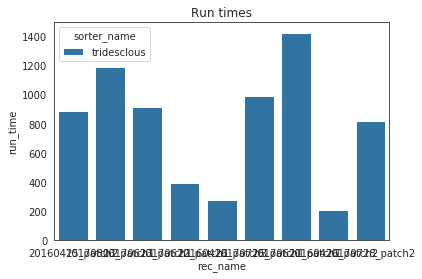

In [11]:
run_times = comp_dataframes['run_times'].reset_index()
fig, ax = plt.subplots()
sns.barplot(data=run_times, x='rec_name', y='run_time', hue='sorter_name', ax=ax)
ax.set_title('Run times')

## Compare performances

In [12]:
comp_dataframes['performances']

,,tp,cl,fp_st1,fp_st2,accuracy,sensitivity,precision,miss_rate,false_disc_rate
rec_name,sorter_name,,,,,,,,,
20160415_patch2,tridesclous,58.9641,0,3105.61,98.1367,1.83941,58.9641,1.86326,41.0359,98.1367
20170803_patch1,tridesclous,99.6466,0,2776.89,96.5359,3.46368,99.6466,3.46411,0.353449,96.5359
20170623_patch1,tridesclous,99.8569,0,21363.5,99.5348,0.46524,99.8569,0.465243,0.143062,99.5348
20170622_patch1,tridesclous,94.6033,0,1019.15,91.5059,8.45315,94.6033,8.49411,5.39675,91.5059
20160426_patch3,tridesclous,0,0,790.538,100,0,0,0,100,100
20170725_patch1,tridesclous,97.3684,0,41466.1,99.7657,0.23425,97.3684,0.234265,2.63158,99.7657
20170621_patch1,tridesclous,0,0,6070.46,100,0,0,0,100,100
20160426_patch2,tridesclous,0,0,499.772,100,0,0,0,100,100
20170728_patch2,tridesclous,99.6841,0,3415.82,97.1644,2.8353,99.6841,2.83556,0.315922,97.1644


(0, 100)

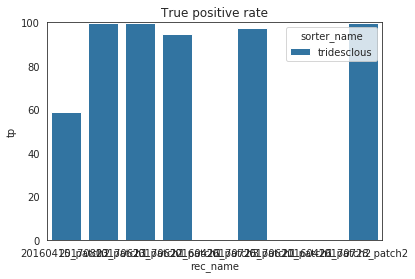

In [14]:
perfs = comp_dataframes['performances'].reset_index()
fig, ax = plt.subplots()
sns.barplot(data=perfs, x='rec_name', y='tp', hue='sorter_name', ax=ax)
ax.set_title('True positive rate')
ax.set_ylim(0, 100)

(0, 100)

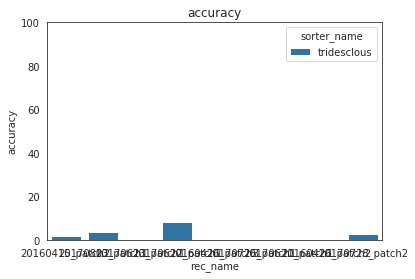

In [16]:
perfs = comp_dataframes['performances'].reset_index()
fig, ax = plt.subplots()
ax = sns.barplot(data=perfs, x='rec_name', y='accuracy', hue='sorter_name', ax=ax)
ax.set_title('accuracy')
ax.set_ylim(0, 100)

# Accuracy vs peak amplitude SNR

In [3]:
# To be done